In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
from google.colab import files
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline,Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,f1_score
from category_encoders import OrdinalEncoder,OneHotEncoder, TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
uploaded =files.upload()

Saving archive.zip to archive (1).zip


In [7]:
!unzip archive.zip

Archive:  archive.zip
replace champion_info.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace champion_info_2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace games.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace summoner_spell_info.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


League of Legends(LOL)라는 게임이 흥행함에 따라 대회 역시 흥행하고 있다 이때 최대의 관심사는 과연 어느팀이 우승할것이냐가 가장 화제가 될것이다. 그렇기에 물론 팀의 컨디션이나 조합등 여러 요인도 승리요인에 작용이 될테지만 현재 게임흐름의 양상에 따른 승리 예측 할 수 있는 모델을 만들고자 한다.

In [8]:
game = pd.read_csv('games.csv')
# champ 관련
#jDict = pd.read_json('champion_info_2.json')
#champInfo = pd.read_json((jDict['data']).to_json(), orient='index')

In [9]:
game

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


In [10]:
champ = [col for col in game.columns if 'champ' in col]
ban = [col for col in game.columns if 'ban' in col]

In [11]:
game_winner = game.copy()
game_winner.drop(columns = champ, inplace = True)
game_winner.drop(columns=ban, inplace = True)

In [12]:
game_winner

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,11,1,2,3,0,5,0,0,1,1
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,10,4,0,2,1,2,0,0,0,0
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,8,1,1,1,0,2,0,0,1,0
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,9,2,1,2,0,0,0,0,0,0
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,2,0,0,0,0,10,2,0,4,0
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,5,4,0,2,0,11,7,4,4,1
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,0,0,0,1,0,10,2,0,2,0
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,0,0,0,0,0,11,3,0,1,0


In [13]:
game_winner[['seasonId']]

,seasonId
0,9
1,9
2,9
3,9
4,9
...,...
51485,9
51486,9
51487,9
51488,9


In [14]:

game_winner.drop(columns = ['gameId', 'creationTime','seasonId'], inplace = True)

In [15]:
first = [col for col in game_winner if 'first' in col]
for col in first:
  game_winner[col].replace(0,'None', inplace = True)
  game_winner[col].replace(1,'Blue', inplace = True)
  game_winner[col].replace(2,'Red', inplace = True)

In [16]:
game_winner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameDuration        51490 non-null  int64 
 1   winner              51490 non-null  int64 
 2   firstBlood          51490 non-null  object
 3   firstTower          51490 non-null  object
 4   firstInhibitor      51490 non-null  object
 5   firstBaron          51490 non-null  object
 6   firstDragon         51490 non-null  object
 7   firstRiftHerald     51490 non-null  object
 8   t1_towerKills       51490 non-null  int64 
 9   t1_inhibitorKills   51490 non-null  int64 
 10  t1_baronKills       51490 non-null  int64 
 11  t1_dragonKills      51490 non-null  int64 
 12  t1_riftHeraldKills  51490 non-null  int64 
 13  t2_towerKills       51490 non-null  int64 
 14  t2_inhibitorKills   51490 non-null  int64 
 15  t2_baronKills       51490 non-null  int64 
 16  t2_dragonKills      51

In [17]:
# 비정상 게임
game_winner[(game_winner['gameDuration']<700) & ((game_winner['t1_towerKills']<11)|(game_winner['t2_towerKills']<11))].sort_values(by='gameDuration')

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
5405,190,1,Red,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0
46157,190,2,Red,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0
34226,191,2,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0
49702,191,1,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0
7447,191,2,Red,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37863,679,2,Red,Red,Red,None,None,None,0,0,0,0,0,8,2,0,0,0
15417,680,1,Red,Blue,Blue,None,None,None,8,1,0,0,0,0,0,0,0,0
16497,681,1,Blue,Blue,Blue,None,None,None,6,1,0,0,0,1,0,0,0,0
18734,684,1,Blue,Blue,Blue,None,None,None,5,1,0,0,0,1,0,0,0,0


In [18]:
game_winner = game_winner[~(game_winner['gameDuration']<700) & ((game_winner['t1_towerKills']<11)|(game_winner['t2_towerKills']<11))]

## 특성 

gameDuration : 게임시간(초)

winner :  승리 팀 (0 = None, 1 = Blue, 2 = Red )   => target

First(선취점)(0 = None, 1=Blue, 2 = Red)

t1,t2 : Blue, Red 게임중 토탈 카운트

              Blood : 킬

              Tower : 타워

              Inhibitor : 억제기

              Baron : 바론

              Dragon : 드래곤

              riftHerald : 전령

## EDA

In [19]:
# target 1 = Blue 2 = Red
game_winner['winner'].value_counts()

1    25441
2    24821
Name: winner, dtype: int64

In [20]:
def spilt (df):
  
  target = 'winner'
  feature = game_winner.drop(columns=target).columns

  X = df[feature]
  y = df[target]

  return X, y

In [21]:
X, y = spilt(game_winner)

In [22]:
X_train, X_test, y_train ,y_test = train_test_split(X, y, train_size=0.8, test_size = 0.2)

In [23]:
X_train

,gameDuration,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
26706,2153,Blue,Red,Blue,Blue,Blue,Red,11,3,1,4,0,3,0,0,0,1
5040,2557,Red,Blue,Red,Blue,Blue,None,11,4,1,3,0,7,1,0,1,0
35911,1635,Red,Red,None,Red,Red,Red,2,0,0,0,0,7,0,1,3,1
8206,1893,Red,Red,Red,None,Red,None,0,0,0,0,0,11,2,0,1,0
24788,1772,Blue,Blue,Red,Red,Red,Blue,2,0,0,0,1,10,2,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,2239,Red,Red,Blue,Red,Blue,Blue,10,2,0,3,1,8,1,1,1,0
21951,1216,Red,Red,None,None,Red,Red,0,0,0,0,0,5,0,0,2,1
11129,2484,Blue,Red,Blue,Red,Blue,None,8,1,1,4,0,4,0,1,0,0
19128,1388,Red,Red,Red,None,Red,None,2,0,0,0,0,9,2,0,2,0


In [24]:
X_train.shape, X_test.shape

((40209, 17), (10053, 17))

In [25]:
y_train.shape, y_test.shape

((40209,), (10053,))

In [26]:
def feature_enginner(df):
  winner = df.copy()
  # 경기 시간을 초,중,후반 으로 나눔
  ten = 600
  condition_list = [
                    (winner['gameDuration'] < (ten*2)),
                    ((winner['gameDuration'] >= (ten*2)) & (winner['gameDuration'] < (ten*3))),
                    ((winner['gameDuration'] >= (ten*3)) & (winner['gameDuration'] < (ten*4))),
                    ((winner['gameDuration'] >= (ten*4)) & (winner['gameDuration'] < (ten*5))),
                    ((winner['gameDuration'] >= (ten*5)) & (winner['gameDuration'] < (ten*6))),
                    (winner['gameDuration'] >= ten*6)
  ]
  time_list = ['10','20','30','40','50','overhour']
  winner['gametime'] = np.select(condition_list,time_list)
  winner.drop(columns = ['gameDuration','t1_riftHeraldKills','t2_riftHeraldKills'], inplace = True)


  return winner

In [27]:
X_train = feature_enginner(X_train)
X_test = feature_enginner(X_test)

In [28]:
X_train

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,gametime
26706,Blue,Red,Blue,Blue,Blue,Red,11,3,1,4,3,0,0,0,30
5040,Red,Blue,Red,Blue,Blue,None,11,4,1,3,7,1,0,1,40
35911,Red,Red,None,Red,Red,Red,2,0,0,0,7,0,1,3,20
8206,Red,Red,Red,None,Red,None,0,0,0,0,11,2,0,1,30
24788,Blue,Blue,Red,Red,Red,Blue,2,0,0,0,10,2,1,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Red,Red,Blue,Red,Blue,Blue,10,2,0,3,8,1,1,1,30
21951,Red,Red,None,None,Red,Red,0,0,0,0,5,0,0,2,20
11129,Blue,Red,Blue,Red,Blue,None,8,1,1,4,4,0,1,0,40
19128,Red,Red,Red,None,Red,None,2,0,0,0,9,2,0,2,20


In [29]:
X_train['gametime'].value_counts()

30          16928
20          16501
40           4316
10           1919
50            510
overhour       35
Name: gametime, dtype: int64

In [30]:
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67     20294
           2       0.00      0.00      0.00     19915

    accuracy                           0.50     40209
   macro avg       0.25      0.50      0.34     40209
weighted avg       0.25      0.50      0.34     40209



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# pipe = make_pipeline(
#     OneHotEncoder(),
#     RandomForestClassifier(random_state=2,n_jobs=-1)
# )

# dists = {
#     'randomforestclassifier__max_depth' : randint(3,10),
#     'randomforestclassifier__n_estimators' : randint(150,300),
#     'randomforestclassifier__min_samples_split' : randint(2,20)

# }

# clf = RandomizedSearchCV(
#     pipe, 
#     param_distributions=dists, 
#     n_iter=50, 
#     cv=4,
#     scoring='f1',
#     verbose=1,
#     n_jobs=-1
# )

# clf.fit(X_train,y_train)

# print(clf.best_score_)
# print(clf.best_params_)

## feature 확인

In [32]:
pipe = make_pipeline(
    TargetEncoder(),
    RandomForestClassifier(random_state=2,n_jobs=-1,max_depth=4, n_estimators=250, min_samples_split=10)
)

In [33]:
permuter = PermutationImportance (
    pipe.named_steps['randomforestclassifier'],
    scoring = 'f1',
    n_iter=5,
    random_state=2
)

In [34]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['firstBlood', 'firstTower',
                                     'firstInhibitor', 'firstBaron',
                                     'firstDragon', 'firstRiftHerald',
                                     'gametime'])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_split=10,
                                        n_estimators=250, n_jobs=-1,
                                        random_state=2))])

In [35]:
X_trans = pipe.named_steps['targetencoder'].transform(X_train)

In [36]:
permuter.fit(X_trans,y_train)
feature_names = X_trans.columns.tolist()

In [37]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names 
)

Weight,Feature
0.0397 ± 0.0020,t2_towerKills
0.0348 ± 0.0016,t1_towerKills
0.0239 ± 0.0015,t1_inhibitorKills
0.0217 ± 0.0012,t2_inhibitorKills
0.0048 ± 0.0008,firstInhibitor
0.0008 ± 0.0004,t2_baronKills
0.0008 ± 0.0003,firstTower
0.0007 ± 0.0001,t1_dragonKills
0.0005 ± 0.0001,t1_baronKills
0.0001 ± 0.0004,firstBaron


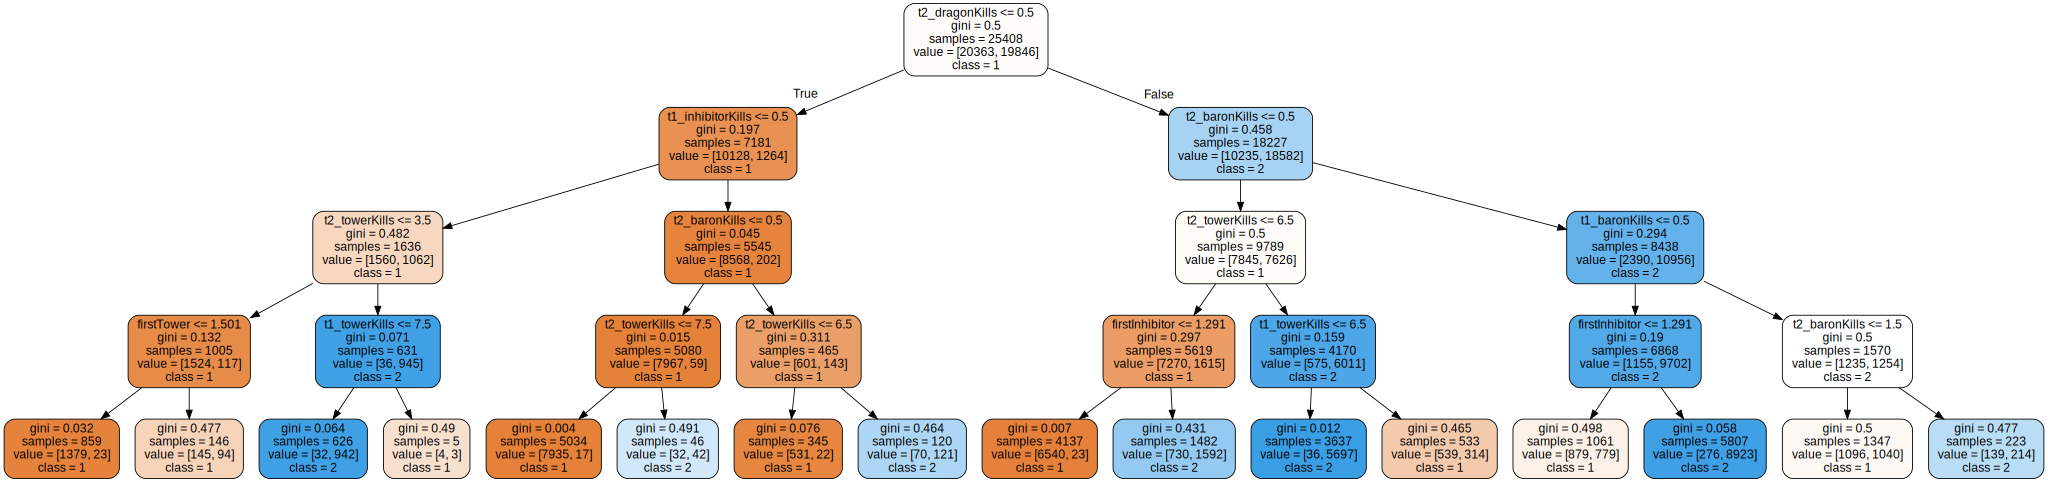

In [38]:
import graphviz
from sklearn.tree import export_graphviz

tree = pipe.named_steps['randomforestclassifier'].estimators_[3]


dot_data = export_graphviz(
    tree,
    feature_names=X_trans.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True,
    rounded=True,
)

graphviz.Source(dot_data)

## 데이터 결과

In [39]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, 
                         scoring='f1')

scores.mean()

0.9737231975827865

In [40]:
y_pred = pipe.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           1       0.97      0.97      0.97     20294
           2       0.97      0.97      0.97     19915

    accuracy                           0.97     40209
   macro avg       0.97      0.97      0.97     40209
weighted avg       0.97      0.97      0.97     40209



In [63]:
value = [['None','None','None','None','None','None',0,0,0,0,0,0,0,0,'20']]
scen = pd.DataFrame(data = value, columns=X_train.columns)


In [64]:
scen

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,gametime
0,None,None,None,None,None,None,0,0,0,0,0,0,0,0,20


In [65]:
y_pred = pipe.predict_proba(scen.iloc[[0]])

print(f'Blue가 이길 확률 : {round(y_pred[0][0]*100,2)}%')
print(f'Red가 이길 확률 : {round(y_pred[0][1]*100,2)}%')

Blue가 이길 확률 : 65.28%
Red가 이길 확률 : 34.72%


In [60]:
value = [['Blue','Red','Red','Red','Red','Red',2,2,1,4,7,2,1,4,'30']]

In [61]:
scen = pd.DataFrame(data = value, columns=X_train.columns)

In [62]:
scen

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,gametime
0,Blue,Red,Red,Red,Red,Red,2,2,1,4,7,2,1,4,30


In [44]:
y_pred = pipe.predict_proba(scen.iloc[[1]])

print(f'Blue가 이길 확률 : {round(y_pred[0][0]*100,2)}%')
print(f'Red가 이길 확률 : {round(y_pred[0][1]*100,2)}%')

Blue가 이길 확률 : 31.77%
Red가 이길 확률 : 68.23%


## 시각화

In [45]:
from sklearn.model_selection import validation_curve

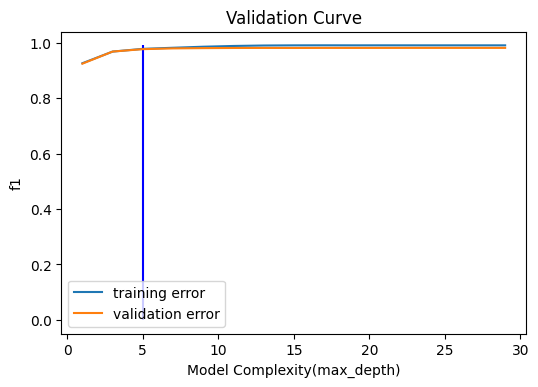

In [46]:
depth = range(1, 30, 2)
ts, vs = validation_curve(
    pipe, X_train, y_train
    , param_name='randomforestclassifier__max_depth'
    , param_range=depth, scoring='f1'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(ts, axis=1)
validation_scores_mean = np.mean(vs, axis=1)

fig, ax = plt.subplots()
ax.plot(depth, train_scores_mean, label='training error')

ax.plot(depth, validation_scores_mean, label='validation error')

ax.vlines(5,0, train_scores_mean.max(), color='blue')

ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='f1')
ax.legend()
fig.dpi = 100

In [47]:
import shap

In [48]:
model = pipe.named_steps['randomforestclassifier']

In [49]:
processor = pipe.named_steps['targetencoder']

In [50]:
row = X_test.iloc[:10000]

In [51]:
explainer = shap.TreeExplainer(model)

In [52]:
processed_row = processor.transform(row)

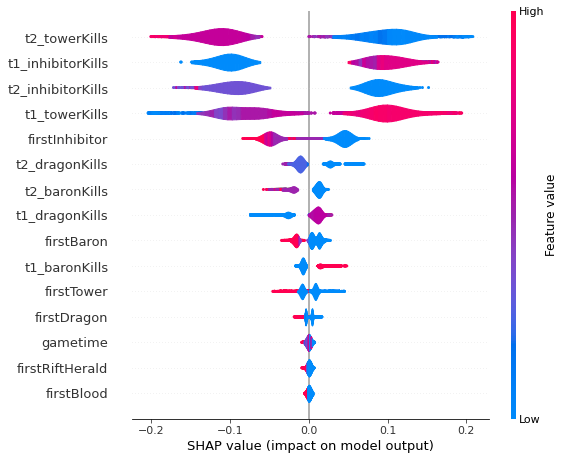

In [53]:
shap_values = explainer.shap_values(processed_row)
shap.summary_plot(shap_values[0],processed_row, plot_type="violin")

In [54]:
eature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))

In [55]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [56]:
print('Blue 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

Blue 예측에 대한 Positive 요인 Top 3 입니다:
1. t1_towerKills : 8
2. t1_inhibitorKills : 1
3. t2_inhibitorKills : 0


Negative 요인 Top 3 입니다:
1. t2_baronKills : 1
2. firstBaron : Red
3. t1_baronKills : 0
